# RAG has two main components:

Indexing (offline) - prepping knowledge base. Takes raw data --> cleans and splits into chunks --> embeds each chunk into vectors using a model --> store these vectors in a vector database

Retrieval and generation (online) - takes user query --> converts into vector embedding --> searches the prebuilt library for the most relevant chunks --> pass chunks along with original question to LLM --> model generates a response using both the question and retrivied context

LangSmith is a tool that helps debug, trace, evaluate, and monitor LLM applications. It it essentially a developer console for LangChain apps

In [25]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

 ········


## Components Set ups

In [33]:
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

llm = init_chat_model("gpt-4o-mini", model_provider="openai")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings)

We will build an app that answer questions on the LLM Powered Autonomous Agents blog post by Lilian Weng

# 1. Indexing

DocumentLoader - object that loads data from a source as list of documents

In [35]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
# USER_AGENT environment variable not set, consider setting it to identify your requests. --> web page that you 
# access expects to include a user-agent as an anti-bot defense
# os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64)" adds this before loader runs

# Only keep post title, headers, and content from the full HTML.
# Soupstrainer is from bs4 that parse certain parts of HTML. Filtering for elements by class names
# helps HTML parse faster and avoids pulling junk like nav bars, ads, etc
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content")) 

loader = WebBaseLoader( #LangChain document loader that fetches web pages
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",), # tuple of URLs to load
    bs_kwargs={"parse_only": bs4_strainer}, # argument to use bs4_strainer
)
docs = loader.load() # fetch and process using bs4_strainer filter

assert len(docs) == 1 # checking to see if loader returned only the document from URL
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [36]:
# docs[0] grab first document (should only be one) 
# page content grabs the actual text and slice the first 500 characters
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


## Splitting Documents

A lot of model have a character limit and even if they do not, those models would struggle to find information in very long inputs.

Question: How does vector searching works? Why do models require chunks of texts instead of whole?

TextSplitter - object that splits a list of documents into smaller chunks

Document Transformer - object that performs a transformation on a list of Document objects

In [37]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# this splitter tries to split on sentences or paragraphs before splitting randomly for more natural chunks
text_splitter = RecursiveCharacterTextSplitter( 
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


## Storing Documents

Turn the 63 chunks into embeddings

Embeddings - wrapper around a text embedding model, used for converting text to embeddings

VectorStore - wrapper around a vector database, used for stroing and querying embeddings

In [38]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['b5111c64-b9c6-4169-a69f-7524f520d149', '7f29bb67-cf31-46f6-a3fa-bcdb68b214cb', 'd9078c3d-dbd2-42c2-8039-8335f79a5e3c']


# 2. Retrieval and Generation

In [39]:
# github for prompts and chains as it stores reuseable components like prompts, chains, and tools 
# created by the LangChain community and LangChain team
from langchain import hub 

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt") # prebuilt RAG prompt

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


## LangGraph 
makes it easier to build complex, multi-step LLM applications such as
- RAG: each step is modular and traceable; easily modify or replace parts like changing retriever (fetches relevant info based on user's query)
- Agent workflows: agents are LLMs that decide what tools (external functions / APIs) to use; LangGraph lets define "thinking" (gets query --> need tool? which one? --> return a plan/action)
- Human-in-the-loop tools: LangGraph lets you insert a "wait for human approval" node
- Streaming chat apps: Handle real-time inputs/outputs; LangGraph allows streaming (sening LLM's output as it is being generated, making it more interactive and responsive) outputs from LLM node-by-node while maintaining structured flow

LangGraph allows to define app once and done and it can do
- One-time logic defintion: define app logic once as a graph and gets support for
    - sync execution - one step after another
    - async execution - let other things happen while waitinf for slow operations
    - streaming - sends outputs as it is being generated
    - batches - process mutiple inputs at once
- Easy deployment: deploy app as an API using LangGraph platform and LangServe
- Langsmith tracing: every node execution is automatically logged to LangSmith (prompts, outputs, errors, timing), making debugging and optimation easier
- Modularity: allow to plug in new features such as, adding memory, insert a human review step, save and load state from a database, add retry logic, tool usage, logging, etc

Need to define three things to use LangGraph:
1. States of our appliaction
2. Nodes of our application (application steps)
3. "Control flow" of our application (ordering of steps)

## State
State of our application controls what data is input to the application.

In [40]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict): # usually a TypedDict but can also be the Pydantic BaseModel
    question: str
    context: List[Document]
    answer: str

## Nodes (application steps)

Retrieval runs a similary search using the input question and the generation step retrieved context and original question into a prompt for GPT

In [41]:
def retrieve(state: State): 
    # .similarity_search(state["question"]) queries vector store to retrieve relevant documents
    # to answer the user's questions
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    # LLM work best when given big, clean context block
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    # produces a chat message structure that LLm expects in chat-based models
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

## Control Flow
Compile application into a single graph object

In [42]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

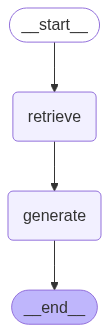

In [43]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Usage

In [44]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='1c7e6239-cf0d-40eb-b679-8393bfaa4571', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool,

## Streaming
The two examples below are synchronous

In large scale application or handling mutiple unpits, async is better. 

In [52]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='1c7e6239-cf0d-40eb-b679-8393bfaa4571', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to a

In [51]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| De|composition| is| the| process| of| breaking| down| a| complex| task| into| smaller|,| manageable| sub|-t|asks|.| This| can| be| achieved| through| various| methods|,| such| as| prompting| large| language| models| (|LL|Ms|),| using| task|-specific| instructions|,| or| incorporating| human| inputs|.| By| decom|posing| tasks|,| it| enhances| planning| and| execution| efficiency|,| allowing| for| better| organization| and| understanding| of| the| task| at| hand|.||

## Returning Sources

The retriever node fetches relevant documents based on question. These documents are stored in graph state in the field state["context"].

In [54]:
print(result["context"])

[Document(id='1c7e6239-cf0d-40eb-b679-8393bfaa4571', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming

## Customizing the Prompt

In [65]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible. Be as passive-aggressive as possible.
Always provide the context and say "Screw you" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""

def test_generate(state: State):
    # LLM work best when given big, clean context block
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    # produces a chat message structure that LLm expects in chat-based models
    messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}
    
custom_rag_prompt = PromptTemplate.from_template(template)

graph_builder = StateGraph(State).add_sequence([retrieve, test_generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

for step in graph.stream(
    {"question": "Give me the summary"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='428d3aed-7bbc-4d97-ad83-45cc26f19a41', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 30868}, page_content='Here are a sample conversation for task clarification sent to OpenAI ChatCompletion endpoint used by GPT-Engineer. The user inputs are wrapped in {{user input text}}.\n[\n  {\n    "role": "system",\n    "content": "You will read instructions and not carry them out, only seek to clarify them.\\nSpecifically you will first summarise a list of super short bullets of areas that need clarification.\\nThen you will pick one clarifying question, and wait for an answer from the user.\\n"\n  },\n  {\n    "role": "user",\n    "content": "We are writing {{a Super Mario game in python. MVC components split in separate files. Keyboard control.}}\\n"\n  },\n  {\n    "role": "assistant",'), Document(id='d271f193-ef8a-4b09-984d-6f9ea9444b7c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent

## Query Analysis
Query analysis - usiong an LLM to interpret, clean, or optimize a user's input before it is userd to search for documents
- Model can rewrite, simplifiy, or rephrase user's query
- Extract true intent
- Add filters (date range, category, etc)
- Remove irrelevant or noisy parts

In [70]:
# adding in contrived sections to the document so we can filter later so show as an example
total_documents = len(all_splits) # get the total number of documents
third = total_documents 

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning" # .metadata dictionary is fully customizable
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

Updating documents in our vector database

In [71]:
vector_store = InMemoryVectorStore(embeddings) # clearing the store
_ = vector_store.add_documents(all_splits) # adding in the new store

Defining a schema for search query

In [74]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""
    # Annotated lets you attach extra informatiuon to a type like descriptions, constraints, or metadata without changing the type itself
    # x : y --> how you define schema in Python
    query: Annotated[str, ..., "Search query to run."] # core is str, ... means you can't leave this empty, "Search query.." is just a description
    section: Annotated[
        Literal["beginning", "middle", "end"], # literal restricts a variable to a fixed set of values 
        ...,
        "Section to query.",
    ]

Adding the step to our LangGraph application

In [75]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search) # wraps LLM to output a structure answer based on Search schema
    query = structured_llm.invoke(state["question"]) # called the structured LLm with user's original question
    return {"query": query} # return query dictionary wrapped in another dictionary


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        # only keep documents where "section" in document's metadata matches the section from the LLm query
        filter=lambda doc: doc.metadata.get("section") == query["section"], 
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"]) # join the actual text of each document in context into a big string
    messages = prompt.invoke({"question": state["question"], "context": docs_content}) # format inputs into a LLM prompts
    response = llm.invoke(messages) # get answer from LLM
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

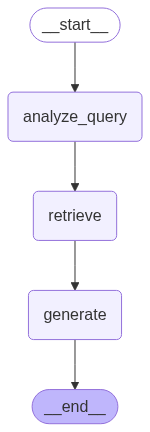

In [76]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [77]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='a5f6537e-e4ba-4b11-bb99-03f8bff2795c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578, 'section': 'beginning'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsour

In [78]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'What is Task Decomposition?', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='a5f6537e-e4ba-4b11-bb99-03f8bff2795c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578, 'section': 'beginning'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an exis

In [84]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

{"query":"Task Decomposition","section":"beginning"}Task decomposition is the process of breaking down a complicated task into smaller, manageable steps. This can be achieved using techniques such as simple prompting, task-specific instructions, or human inputs. It enhances problem-solving and planning abilities by structuring complex tasks into subgoals and thought processes.

## For Convenience

In [ ]:
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()